<a href="https://colab.research.google.com/github/souhaib-coder/demandforecasting/blob/main/demandForecastingML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# 1. Charger les données
import pandas as pd
import numpy as np
import datetime

# Charger le fichier Excel
df = pd.read_excel(
    "/content/Planning Salé 08_07_2025 V12.xlsx",
    sheet_name="Planning Fab"
)
for i in range(9):
  df=df.drop(index=i)
df = df.reset_index(drop=True)
df=df.drop(columns=[200,"Unnamed: 1","Unnamed: 5"])
df=df.T
df = df.reset_index(drop=True)
# Convert the date column to datetime, coercing errors
df[0] = pd.to_datetime(df[0], errors='coerce')

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/tmp/ipython-input-70-1476543283.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[0] = pd.to_datetime(df[0], errors='coerce')


In [151]:
row,colums=df.shape
dff=pd.DataFrame()
colonnes = [
    'Code A', 'Stock Global', 'Stock Agences', 'Prévs', 'Réalisation',
    'CV Globale', 'CV Agences', 'Déblocage', 'Ventes Réelles', 'PPED',
    'Ecart Réalisé / Planifié', 'Ecart Ventes / Prévs',
    'Ecart Ventes+PPED / Prévs', 'PSL', 'Fab Prévue', 'date'
]

# Création du DataFrame vide
df_Final = pd.DataFrame(columns=colonnes)
produits=set(df.iloc[0])
produits = {x for x in produits if not pd.isna(x)}- {'Code A'}
for produit in produits:
  dff=df.loc[:, df.loc[0]==produit]
  dff = dff.reset_index(drop=True)
  dff_gamme=dff.iloc[1,1]
  dff.columns=dff.iloc[3]
  dff=dff.drop(index=[0,1,2,3])
  # Étape 1 : Trouver toutes les colonnes nommées "A"
  a_cols = dff.loc[:, dff.columns == 'Fab Prévue']
  # Étape 2 : Faire la somme ligne par ligne
  a_sum = a_cols.sum(axis=1)
  # Étape 3 : Supprimer les colonnes "A" (toutes)
  dff = dff.loc[:, dff.columns != 'Fab Prévue']
  # Étape 4 : Ajouter une nouvelle colonne "A" avec la somme
  dff['Fab Prévue'] = a_sum
  dff['date'] =pd.to_datetime(df.iloc[4:, 0], errors='coerce').dt.date
  dff = dff.dropna(axis=1, how='all')
  dff=dff.reset_index(drop=True)
  dff.insert(0, 'Code A', [produit] * len(dff))
  dff.insert(1, 'Gamme', [dff_gamme] * len(dff))
  for j in dff.index:
    Glo,Age,Pre = dff.loc[j,'Stock Global'],dff.loc[j,'Stock Agences'],dff.loc[j,'Prévs']
    if ((pd.isna(Glo) or Glo<=0 or Glo<1e-8) and (pd.isna(Age) or Age==0 or Age<1e-8)):
      dff=dff.drop(index=j)
    elif (pd.isna(Glo) or Glo==0):
      dff=dff.drop(index=j)
  df_Final=pd.concat([df_Final,dff], ignore_index=True)
df_Final = df_Final.iloc[:, :-1]
df_Final = df_Final[df_Final['date'] != datetime.date(1970, 1, 1)]

In [152]:
def pourcentage_nan(df):
  # Nombre total de lignes
  total = len(df)

  # Nombre de NaN par colonne
  nb_nan = df.isna().sum()

  # Pourcentage de NaN par colonne
  pourcentage = (nb_nan / total) * 100
  display(pourcentage)

In [153]:
pourcentage_nan(df_Final)

,0
Code A,0.000000
Stock Global,0.000000
Stock Agences,0.000000
Prévs,0.714942
Réalisation,0.398325
CV Globale,3.329588
CV Agences,2.389950
Déblocage,0.000000
Ventes Réelles,53.130426
PPED,57.665203


In [154]:
# Liste des colonnes à exclure
#Ces colonnes ont un pourcentage très élevé de valeurs NaN, ce qui est difficile à gérer pour le modèle.
colonnes_a_exclure = ['PSL', 'Ecart Ventes+PPED / Prévs', 'Ecart Ventes / Prévs','PPED']

# Création d'un nouveau DataFrame sans ces colonnes
df_cleaned = df_Final.drop(columns=colonnes_a_exclure)
df_cleaned.columns

Index(['Code A', 'Stock Global', 'Stock Agences', 'Prévs', 'Réalisation',
       'CV Globale', 'CV Agences', 'Déblocage', 'Ventes Réelles',
       'Ecart Réalisé / Planifié', 'Fab Prévue', 'date', 'Gamme'],
      dtype='object')

In [155]:
df_cleaned['Code A'] = df_cleaned['Code A'].astype(str)
df_cleaned['Stock Global'] = pd.to_numeric(df_cleaned['Stock Global'], errors='coerce')
df_cleaned['Stock Agences'] = pd.to_numeric(df_cleaned['Stock Agences'], errors='coerce')
df_cleaned['Prévs'] = pd.to_numeric(df_cleaned['Prévs'], errors='coerce')
df_cleaned['Réalisation'] = pd.to_numeric(df_cleaned['Réalisation'], errors='coerce')
df_cleaned['CV Globale'] = pd.to_numeric(df_cleaned['CV Globale'], errors='coerce')
df_cleaned['CV Agences'] = pd.to_numeric(df_cleaned['CV Agences'], errors='coerce')
df_cleaned['Déblocage'] = pd.to_numeric(df_cleaned['Déblocage'], errors='coerce')
df_cleaned['Ventes Réelles'] = pd.to_numeric(df_cleaned['Ventes Réelles'], errors='coerce')
df_cleaned['Ecart Réalisé / Planifié'] = pd.to_numeric(df_cleaned['Ecart Réalisé / Planifié'], errors='coerce')
df_cleaned['Fab Prévue'] = pd.to_numeric(df_cleaned['Fab Prévue'], errors='coerce')
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')
df_cleaned['Gamme'] = df_cleaned['Gamme'].astype(str)
df_cleaned.shape

(9791, 13)

In [135]:
#cette focntion pour verifier les valeur null avant et apres ;l'appliaction de la condition de filtrage des nan et 0
def count_nan_zero_per_month(df, date_col='date', value_cols=['Stock Global', 'Stock Agences', 'Prévs']):
    # S'assurer que la colonne date est au format datetime
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Extraire année + mois pour grouper
    df['year_month'] = df[date_col].dt.to_period('M')

    # Fonction pour compter NaN et 0 dans un groupe
    def count_in_group(group):
        nan_count = group[value_cols].isna().sum().sum()
        zero_count = (group[value_cols] == 0).sum().sum()
        return pd.Series({'nan_count': nan_count, 'zero_count': zero_count})

    # Grouper par année-mois
    result = df.groupby('year_month').apply(count_in_group).reset_index()

    # Convertir 'year_month' en string ou datetime (décommenter selon besoin)
    # result['year_month'] = result['year_month'].dt.to_timestamp()

    return result
counts_month = count_nan_zero_per_month(df_cleaned,value_cols='Stock Agences')
print(counts_month)


  year_month  nan_count  zero_count
0    2024-12          0          18
1    2025-01          0          13
2    2025-02          0          18
3    2025-03          0          14
4    2025-04          0          21
5    2025-05          0           1
6    2025-06          0           3
7    2025-07          0          14
8    2025-08          0          98
9    2025-09          0           4


/tmp/ipython-input-135-2181685830.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('year_month').apply(count_in_group).reset_index()


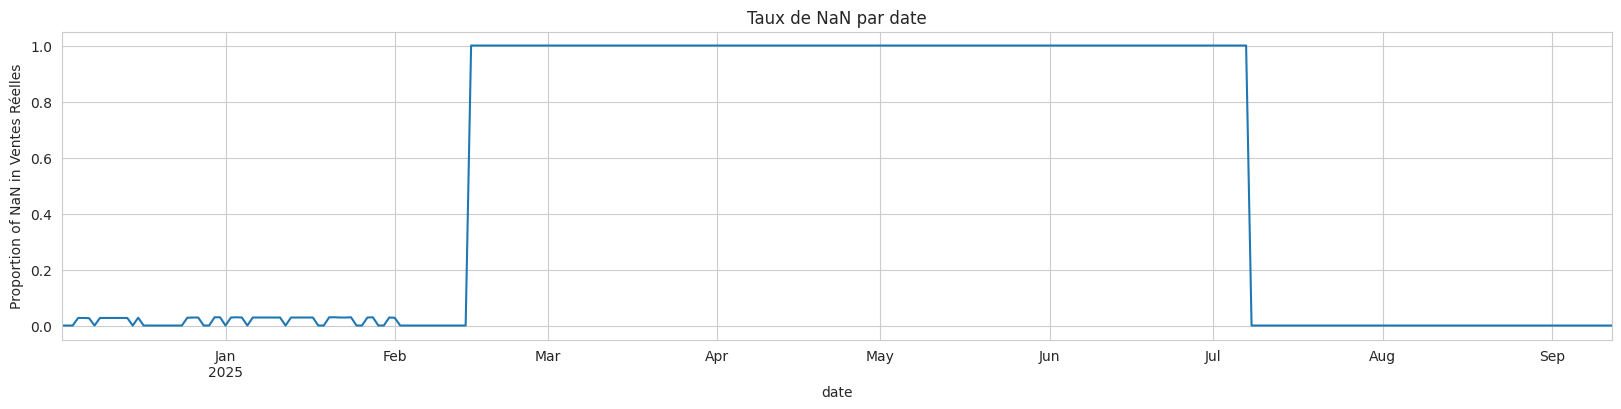

In [156]:
import matplotlib.pyplot as plt

# Afficher la distribution des NaN par date (ou tout autre critère)
df_cleaned['is_nan'] = df_cleaned['Ventes Réelles'].isna()
df_cleaned.groupby('date')['is_nan'].mean().plot(kind='line', figsize=(20,4), title="Taux de NaN par date")
plt.ylabel('Proportion of NaN in Ventes Réelles')
plt.show()

In [149]:
#J'ai dessiné ceci pour visualiser les produits qui n'ont pas d'accès à donner.

'''import matplotlib.pyplot as plt
import seaborn as sns

# Configurer le style des graphiques
sns.set_style("whitegrid")

for produit in produits:
    df_subset = df_cleaned[df_cleaned["Code A"] == produit]
    pourcent_nan = df_subset.isna().mean() * 100

    # Afficher le pourcentage de NaN par colonne pour ce produit
    print(f"Pourcentage de valeurs manquantes pour le produit {produit}:")

    # Créer un graphique à barres pour visualiser le pourcentage de NaN
    plt.figure(figsize=(12, 6))
    sns.barplot(x=pourcent_nan.index, y=pourcent_nan.values)
    plt.xticks(rotation=90)
    plt.title(f'Pourcentage de valeurs manquantes par colonne pour le produit {produit}')
    plt.ylabel('Pourcentage de NaN')
    plt.xlabel('Colonne')
    plt.ylim(0, 100) # Set the y-axis limit to 0-100
    plt.tight_layout()
    plt.show()'''

'import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Configurer le style des graphiques\nsns.set_style("whitegrid")\n\nfor produit in produits:\n    df_subset = df_cleaned[df_cleaned["Code A"] == produit]\n    pourcent_nan = df_subset.isna().mean() * 100\n\n    # Afficher le pourcentage de NaN par colonne pour ce produit\n    print(f"Pourcentage de valeurs manquantes pour le produit {produit}:")\n\n    # Créer un graphique à barres pour visualiser le pourcentage de NaN\n    plt.figure(figsize=(12, 6))\n    sns.barplot(x=pourcent_nan.index, y=pourcent_nan.values)\n    plt.xticks(rotation=90)\n    plt.title(f\'Pourcentage de valeurs manquantes par colonne pour le produit {produit}\')\n    plt.ylabel(\'Pourcentage de NaN\')\n    plt.xlabel(\'Colonne\')\n    plt.ylim(0, 100) # Set the y-axis limit to 0-100\n    plt.tight_layout()\n    plt.show()'

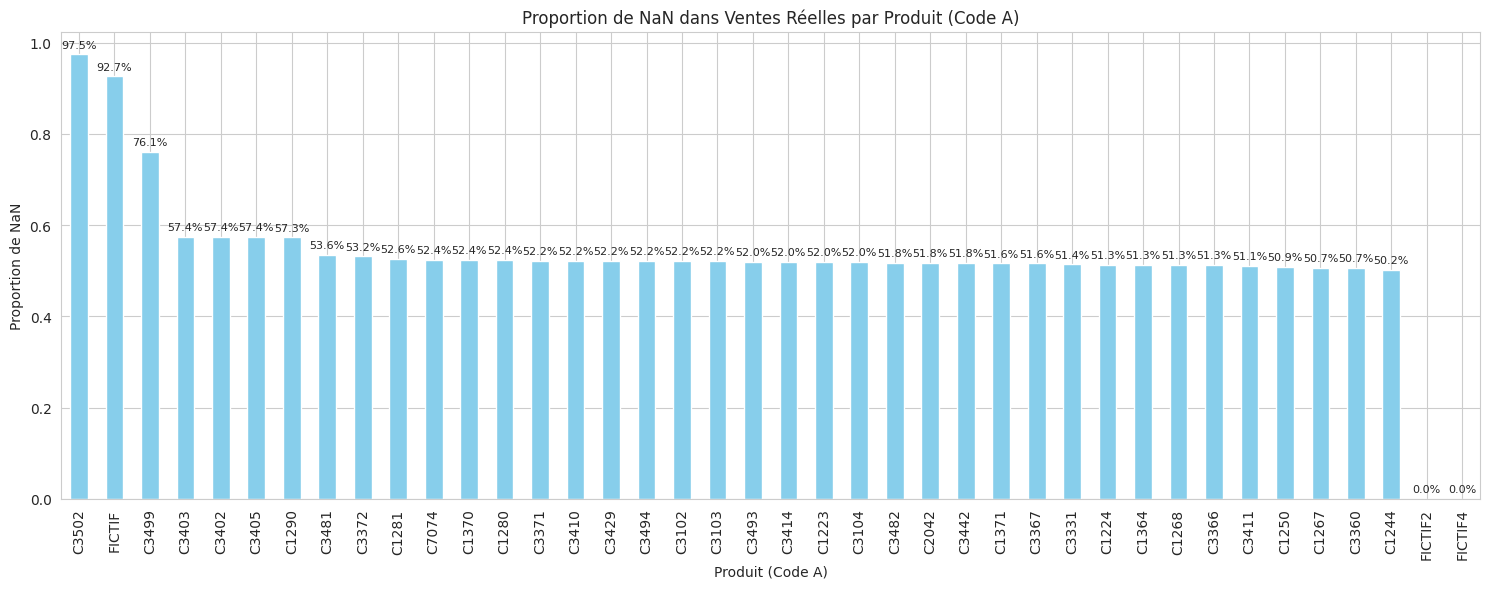

In [157]:
import matplotlib.pyplot as plt

#pour visualiser les produits qui ont des taux de ventes reelle null afin de les eleminers
nan_proportion_by_product = df_cleaned.groupby('Code A')['is_nan'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
nan_proportion_by_product.plot(kind='bar', color='skyblue')
plt.title('Proportion de NaN dans Ventes Réelles par Produit (Code A)')
plt.xlabel('Produit (Code A)')
plt.ylabel('Proportion de NaN')
plt.xticks(rotation=90)
for i, v in enumerate(nan_proportion_by_product):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()


In [144]:
#Je vais supprimer les produits suivants car leurs données ne sont pas exploitables.
df_cleaned = df_cleaned[~df_cleaned['Code A'].isin(['FICTIF', 'FICTIF4','FICTIF3','FICTIF2'])]
df_cleaned['Code A'].nunique()

37

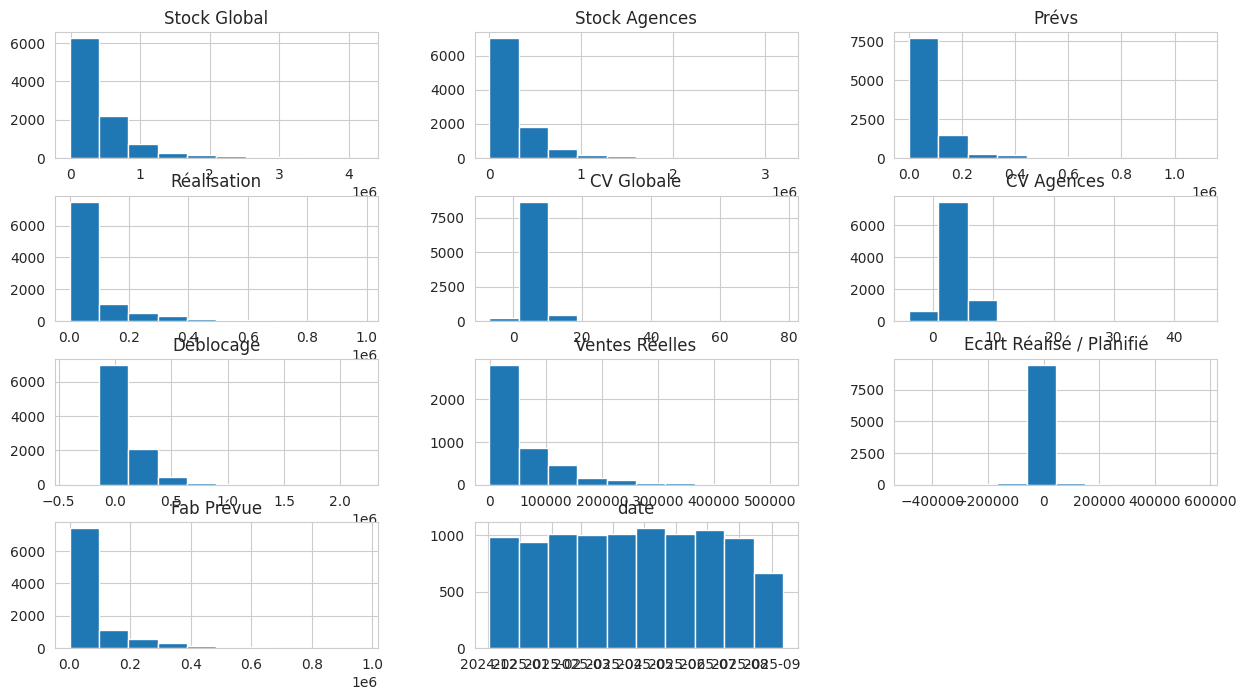

In [148]:
df_cleaned.hist(figsize=(15, 8))
plt.show()

In [ ]:
'''row,colums=df.shape
dff=pd.DataFrame()
n=0
for i in range(1,colums):
  CodeA=df.iloc[0,i]
  df_name=df.iloc[1,i]+df.iloc[2,i]
  if pd.isna(CodeA):
    break
  if (CodeA==df.iloc[0,i+1] and i+1 < colums):
        dff[df.iloc[3,i]]=df.iloc[4:,i]
  else:
    try:
      dff['date'] = pd.to_datetime(df.iloc[4:, 0]).dt.strftime('%Y-%m-%d')
      for j in dff.index:
          Glo,Age,Pre = dff.loc[j,'Stock Global'],dff.loc[j,'Stock Agences'],dff.loc[j,'Prévs']
          if ((pd.isna(Glo) or Glo<=0 or Glo<1e-8) and (pd.isna(Age) or Age==0 or Age<1e-8)):
              dff=dff.drop(index=j)
          elif (pd.isna(Glo) or Glo==0):
              dff=dff.drop(index=j)
    except Exception as e:
      print(dff.columns)
      print(df_name)
    dff.to_excel(df_name+".xlsx", index=False)
    dff=pd.DataFrame()'''
#first attempt

In [2]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.9 MB/s eta 0:00:00
